In [1]:
# Load .env and display model environment variables used by agents
import os
from dotenv import load_dotenv
load_dotenv()
print({k: os.getenv(k) for k in [
    "MODEL_NAME",
    "TEACHER_MODEL",
    "GRADING_MODEL",
    "COORDINATOR_MODEL",
    "STUDENT_MODEL",
    "CRITIQUE_EVAL_MODEL",
]})

{'MODEL_NAME': 'gpt-4o-mini', 'TEACHER_MODEL': 'gpt-4o-mini', 'GRADING_MODEL': 'gpt-4o-mini', 'COORDINATOR_MODEL': 'gpt-4o-mini', 'STUDENT_MODEL': 'gpt-4o-mini', 'CRITIQUE_EVAL_MODEL': 'gpt-4o-mini'}


In [2]:
# imports and config constants (refactored to per-agent modules)
import os, json, pathlib
from datetime import datetime
from typing import Dict, List
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import importlib


sys.path.insert(0, str(Path.cwd().parent))  # add repo root

from src.agents.common import PERSONAS, StopConfig
from src.agents.coordinator_agent import coordinator_node
from src.agents.teacher_agent import teacher_node
from src.agents.student_agent import students_node
from src.agents.critique_eval_agent import reward_node
from src.agents.stopping_agent import stopper_node
import src.agents.grading_agent as grading_agent_mod
importlib.reload(grading_agent_mod)
from src.agents.grading_agent import grading_node
from src.utils.gpqa_loader import GPQALoader

THRESHOLD = 0.7
MAX_ITERS = 5
BASE_OUT = pathlib.Path("results")
BASE_OUT.mkdir(parents=True, exist_ok=True)

In [3]:
# optional: initialize TruLens OpenAI provider to compute simple relevance
try:
    from trulens.providers.openai import OpenAI as TruOpenAI
    tru_provider = TruOpenAI(model_engine="gpt-4o-mini")
except Exception as e:
    tru_provider = None
    print("TruLens provider init failed:", e)


def trulens_relevance(question: str, explanation: str):
    """Return a simple relevance score via TruLens provider, or None if unavailable."""
    if tru_provider is None:
        return None
    try:
        res = tru_provider.relevance_with_cot_reasons(question, explanation)
        # Try to normalize to float if structure varies across versions
        if isinstance(res, dict):
            for k in ("score", "value", "score_value"):
                if k in res and res[k] is not None:
                    return float(res[k])
            return None
        # object-like
        score = getattr(res, "score", None) or getattr(res, "value", None)
        return float(score) if score is not None else None
    except Exception:
        return None

In [4]:
# build LangGraph graph for multi-agent refinement + TruLens session
from typing import Dict, List, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END

class State(TypedDict, total=False):
    question: str
    topics: List[str]
    explanation: str
    student_responses: Dict[str, str]
    reward_scores: Dict[str, int]
    history: List[Dict]
    iteration: int
    threshold: float
    max_iters: int
    decision: str
    reason: str
    quiz: List[Dict[str, Any]]
    quiz_answers: Dict[str, Dict[str, str]]
    quiz_justifications: Dict[str, Dict[str, str]]
    quiz_results: Dict[str, Any]
    gpqa_quiz: List[Dict[str, Any]]

# assemble graph with nodes imported from src.agents.* modules
graph = StateGraph(State)

graph.add_node("coordinator", coordinator_node)

graph.add_node("teacher", teacher_node)

graph.add_node("students", students_node)


graph.add_node("reward", reward_node)

graph.add_node("stopper", stopper_node)

graph.add_node("grading", grading_node)

# edges
graph.add_edge("coordinator", "teacher")
graph.add_edge("teacher", "students")
graph.add_edge("students", "reward")
graph.add_edge("reward", "stopper")
graph.add_edge("grading", END)

# on CONTINUE, recompute topics first, then go to teacher

def route_from_stop(state: State) -> str:
    return "grading" if state.get("decision") == "STOP" else "coordinator"

graph.add_conditional_edges("stopper", route_from_stop, {"grading": "grading", "coordinator": "coordinator"})

graph.set_entry_point("coordinator")
compiled_graph = graph.compile()

# TruLens LangGraph recorder (logs interactions)
try:
    from trulens.core.database.connector.default import DefaultDBConnector
    from trulens.core.session import TruSession
    from trulens.apps.langgraph import TruGraph

    connector = DefaultDBConnector(database_url="sqlite:///edu_refine.sqlite")
    tru_session = TruSession(connector=connector)
    tru_recorder = TruGraph(compiled_graph, app_name="Educational Refinement Agent", app_version="mvp")
except Exception as e:
    tru_recorder = None
    print("TruGraph init failed:", e)

🦑 Initialized with db url sqlite:///edu_refine.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.
✅ experimental Feature.OTEL_TRACING enabled.
🔒 experimental Feature.OTEL_TRACING is enabled and cannot be changed.
instrumenting <class 'langgraph.graph.state.StateGraph'> for base <class 'langgraph.graph.state.StateGraph'>
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.graph.state.CompiledStateGraph'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.pregel.main.Pregel'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream


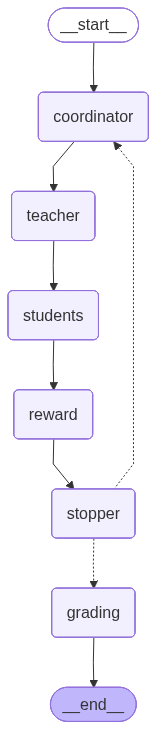

In [5]:

from IPython.display import Image

display(Image(compiled_graph.get_graph().draw_mermaid_png()))


In [6]:
import json, random
from pathlib import Path

# Seeded GPQA sampling
SEED = 42
rng = random.Random(SEED)

# Load GPQA (ensure you've run scripts/download_gpqa.py)
from src.utils.gpqa_loader import GPQALoader
subset = "gpqa_main"
domain = "Physics"
loader = GPQALoader(subset, domain)

# Sample one question deterministically
idx = rng.randrange(len(loader))
q = loader[idx]
record_id = q.get("record_id", q.get("id"))
stem = q.get("question", "").strip()

# Build deterministic options and correct letter
letters = ["A", "B", "C", "D"]
option_items = [("correct", q.get("correct_answer", ""))]
for wrong in (q.get("incorrect_answers") or [])[:3]:
    option_items.append(("incorrect", wrong))
# Deterministic shuffle
rng.shuffle(option_items)
options_text = [f"{letters[i]}) {option_items[i][1]}" for i in range(4)]
correct_letter = letters[[i for i, t in enumerate(option_items) if t[0] == "correct"][0]]

# Assemble single-question quiz for grading agent
GPQA_QUIZ = [{
    "id": str(record_id),
    "stem": stem,
    "options": options_text,
    "correct": correct_letter,
}]

QUESTION = stem

initial_state = {
    "question": QUESTION,
    "threshold": THRESHOLD,
    "max_iters": MAX_ITERS,
    "history": [],
    "gpqa_quiz": GPQA_QUIZ,
}

if 'tru_recorder' in globals() and tru_recorder is not None:
    with tru_recorder as recording:
        state = compiled_graph.invoke(initial_state, config={"recursion_limit": 30})
else:
    state = compiled_graph.invoke(initial_state, config={"recursion_limit": 30})

results = {
    "dataset": "GPQA",
    "subset": subset,
    "domain": domain,
    "gpqa_index": idx,
    "record_id": record_id,
    "question": state.get("question", QUESTION),
    "topics": state.get("topics", []),
    "iterations": state.get("iteration", 0),
    "final_scores": state.get("reward_scores", {}),
    "final_explanation": state.get("explanation", ""),
    "history": state.get("history", []),
    "quiz": state.get("quiz", GPQA_QUIZ),
    "quiz_answers": state.get("quiz_answers", {}),
    "quiz_justifications": state.get("quiz_justifications", {}),
    "quiz_results": state.get("quiz_results", {}),
}

print("Dataset:", results["dataset"], results["subset"], results["domain"]) 
print("Record ID:", results["record_id"]) 
print("Question:", results["question"]) 
print("Topics:", ", ".join(results["topics"]))
print("Iterations:", results["iterations"]) 
print("Final scores:", results["final_scores"]) 
print("\nFinal explanation (truncated to 800 chars):\n")
print(results["final_explanation"][:800])

# Print quiz and persona answers with justifications
quiz = results.get("quiz", [])
answers = results.get("quiz_answers", {})
justifs = results.get("quiz_justifications", {})
if quiz:
    q0 = quiz[0]
    print("\nQuiz (GPQA single question):")
    print(f"- ID: {q0.get('id','')}")
    print(f"  Stem: {q0.get('stem','').strip()}")
    for opt in q0.get("options", []):
        print(f"  {opt}")
    print(f"  Correct: {q0.get('correct','?')}")

    if answers:
        print("\nStudent answers and justifications:")
        for p in sorted(answers.keys()):
            a_map = answers.get(p, {})
            j_map = justifs.get(p, {})
            letter = a_map.get(str(q0.get('id')), '?')
            jtxt = j_map.get(str(q0.get('id')), '')
            print(f"- {p}: {letter}")
            if jtxt:
                print(f"  Justification: {jtxt}")

quiz_results = results.get("quiz_results", {})
if quiz_results:
    total = quiz_results.get("total_questions", 0)
    overall = quiz_results.get("overall_score", 0.0)
    scores_by_persona = quiz_results.get("scores_by_persona", {})
    correct_counts = quiz_results.get("correct_counts", {})
    just_scores = quiz_results.get("justification_scores_by_persona", {})
    print("\nQuiz Results:")
    print(f"- Total questions: {total}")
    print(f"- Overall score: {overall*100:.1f}%")
    print("- Scores by persona:")
    for p in sorted(scores_by_persona.keys()):
        sc = scores_by_persona[p]
        cc = correct_counts.get(p, 0)
        js = just_scores.get(p, 0.0)
        print(f"  {p}: {sc*100:.1f}% (correct {cc}/{total}, justification {js*100:.1f}%)")

# Persist results to results/ with timestamped filename
_ts = datetime.now().strftime("%Y%m%d_%H%M%S")

def _slugify(s: str, limit: int = 40) -> str:
    s = (s or "").strip()
    slug = "".join(ch if ch.isalnum() else "_" for ch in s)
    return slug[:limit] if limit > 0 else slug

_id_part = str(record_id) if record_id is not None else _slugify(results["question"]) or "run"
outfile = BASE_OUT / f"run_{_ts}_{_id_part}.json"
record = {
    "timestamp": _ts,
    "dataset": results["dataset"],
    "subset": results["subset"],
    "domain": results["domain"],
    "gpqa_index": idx,
    "record_id": record_id,
    "question": results["question"],
    "final_explanation": results["final_explanation"],
    "topics": results["topics"],
    "iterations": results["iterations"],
    "final_scores": results["final_scores"],
    "quiz": results.get("quiz", []),
    "quiz_answers": results.get("quiz_answers", {}),
    "quiz_justifications": results.get("quiz_justifications", {}),
    "quiz_results": results.get("quiz_results", {}),
}
outfile.write_text(json.dumps(record, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"\nSaved results to: {outfile}")

C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics.json
Loading GPQA cache from: C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics.json
Loaded 187 Physics questions from gpqa_main
Dataset: GPQA gpqa_main Physics
Record ID: recvlnu8BuLmXZhSX
Question: The state of a system at time t is given by the column matrix having elements (-1, 2, 1). An observable of the system is represented by the matrix operator P having elements in the first row as (0, 1/ \sqrt{2}, 0),  in the second row as (1/ \sqrt{2}, 0, 1/ \sqrt{2}) and in the third row as (0, 1/ \sqrt{2}, 0). Calculate the probability that the measurement of the observable will yield 0 at time t.
Topics: Understanding the physical significance of the norm squared, Step-by-step calculation of the total norm squared of the state vector, Detailed explanation of projection operators and their mathematical properties, Connection between projection operators and measurement outcom

In [7]:
# launch TruLens dashboard to view agent interactions
from trulens.dashboard import run_dashboard
run_dashboard()  # prints a local URL (e.g., http://localhost:8501); open it in your browser

Starting dashboard ...


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://localhost:52154 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>